In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad
from scipy.integrate import solve_ivp
import tqdm
from torch.utils.data import TensorDataset, DataLoader

\begin{equation} 
\left( \frac{du}{d\phi} \right) ^{2}=\left( \frac{r_{s}}{b} \right) ^{2}+u^{3}-u^{2} 
\end{equation}

$$u(\phi_0) = u_0,\, b$$

siendo las variables de este modelo

In [84]:
def du_dphi(phi, u, rs, b):
    """
    RHS of du/dphi = sqrt((rs/b)^2 + u^3 - u^2)
    """
    expr = (rs / b)**2 + u[0]**3 - u[0]**2
    if expr < 0:
        return [0.0]  # parada segura
    return [np.sqrt(expr)]

def solve_u(phi_range, u0, rs=2.0, b=5.0, n_points=300):
    """
    Soluciona la EDO para u(φ) con condición inicial u(φ₀) = u₀.
    """
    phi_vals = np.linspace(phi_range[0], phi_range[1], n_points)
    y0 = [u0]
    sol = solve_ivp(
        fun=lambda phi, u: du_dphi(phi, u, rs, b),
        t_span=phi_range,
        y0=y0,
        t_eval=phi_vals,
        method='RK45',
        rtol=1e-6,
        atol=1e-9
    )

    if not sol.success:
        raise RuntimeError(f"Integración fallida: {sol.message}")
    return sol.t, sol.y[0]


# Parámetros ajustables
u0 = 0.01    # Puedes cambiar esto
b = 5.0        # Y también esto
rs = 4.0
phi_range = (0.1, 6.5)

def cartesian_orbit(phi, u, rs=1.0):
    r = rs / u
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return x, y

# Resolver y graficar
try:
    phi, u = solve_u(phi_range, u0=u0, rs=rs, b=b)

    # Gráfico de u(φ)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(phi, u, label=fr'$u(\phi)$ con $u_0={u0}$, $b={b}$')
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$u(\phi)$')
    plt.grid(True)
    plt.legend()
    plt.title('Solución numérica $u(\phi)$')

    # Gráfico de órbita cartesiana
    valid = u > 0
    if np.any(valid):
        x, y = cartesian_orbit(phi[valid], u[valid], rs=rs)
        plt.subplot(1, 2, 2)
        plt.plot(x, y, label='Órbita (numérica)')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Órbita cartesiana')
        plt.axis('equal')
        plt.grid(True)
        plt.legend()
    else:
        print("[Aviso] u <= 0 en todo el dominio, no se puede calcular la órbita.")

    plt.tight_layout()
    plt.show()

except RuntimeError as e:
    print(f"[Error] Falló la integración: {e}")


[Error] Falló la integración: Integración fallida: Required step size is less than spacing between numbers.


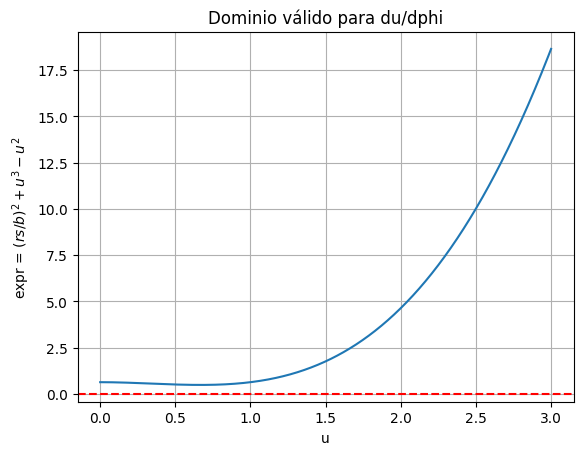

In [78]:
import numpy as np
import matplotlib.pyplot as plt

rs = 4.0
b = 5.0
const_term = (rs / b)**2

u = np.linspace(0, 3, 1000)
expr = const_term + u**3 - u**2

plt.plot(u, expr)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('u')
plt.ylabel('expr = $(rs/b)^2 + u^3 - u^2$')
plt.title('Dominio válido para du/dphi')
#plt.xscale('log')
#plt.yscale('log')
plt.grid(True)
plt.show()


In [35]:
def nth_derivative(net, x: torch.Tensor, j: int, i: int, n: int) -> torch.Tensor:
    """
    Calcula la n-ésima derivada de la componente j del output de una red `net`
    respecto a la variable i de entrada `x`.

    Args:
        net (nn.Module): red neuronal
        x (Tensor): entrada (batch_size, num_vars)
        j (int): índice de la salida a derivar
        i (int): índice de la variable respecto a la que se deriva
        n (int): orden de la derivada

    Returns:
        Tensor: derivada n-ésima, shape (batch_size, 1)
    """
    if not x.requires_grad:
        x = x.clone().detach().requires_grad_(True)

    out = net(x)[:, j].view(-1, 1)
    for _ in range(n):
        grads = torch.autograd.grad(
            out, x,
            grad_outputs=torch.ones_like(out),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        out = grads[:, i].view(-1, 1)
    return out



def plot_training_error(errors):
    """
    Grafica el error de entrenamiento (loss) en escala log-log.
    """
    errors = np.array(errors)  # convierte a numpy si es tensor o lista
    plt.figure(figsize=(8, 4))
    plt.plot(errors, label='Loss')
    plt.xlabel('Iteración')
    plt.ylabel('Loss (log scale)')
    # plt.xscale('log')
    plt.yscale('log')
    plt.title('Evolución del error durante el entrenamiento')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def build_network(n_inputs, n_outputs, n_hidden_layers, n_nodes, activation=nn.Tanh):
    """
    Construye una red feedforward configurable.
    """
    layers = [nn.Linear(n_inputs, n_nodes), activation() if callable(activation) else activation]

    for _ in range(n_hidden_layers - 1):
        layers += [nn.Linear(n_nodes, n_nodes), activation() if callable(activation) else activation]

    layers.append(nn.Linear(n_nodes, n_outputs))
    return nn.Sequential(*layers)


In [36]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")


CUDA is available. Using GPU.


In [37]:
import torch.backends.cudnn
torch.backends.cudnn.benchmark = True

In [38]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Rango de entrenamiento
phi_0, phi_f = 0.0, 6.5
u_0, u_f     = 0.1, 5.0
b_fixed      = 5.0  # b fijo

In [39]:
def sample_batch_fixed_b(batch_size, phi_range, u0_range, b_value):
    phi = torch.rand(batch_size, 1) * (phi_range[1] - phi_range[0]) + phi_range[0]
    u0  = torch.rand(batch_size, 1) * (u0_range[1] - u0_range[0]) + u0_range[0]
    b   = torch.full_like(phi, b_value)  # todos los valores de b son constantes
    return torch.cat([phi, u0, b], dim=1)  # shape: (batch_size, 3)


In [40]:
def make_dataloader_fixed_b(batch_size, n_batches, phi_range, u0_range, b_value, seed=None):
    if seed is not None:
        torch.manual_seed(seed)

    # Genera todos los batches de una vez (opcional, por simplicidad)
    data = []
    for _ in range(n_batches):
        batch = sample_batch_fixed_b(batch_size, phi_range, u0_range, b_value)
        data.append(batch)
    
    data_tensor = torch.cat(data, dim=0)  # (n_batches * batch_size, 3)
    dataset = TensorDataset(data_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader


In [41]:
ANN = build_network(n_inputs=2, n_outputs=1, n_hidden_layers=2, n_nodes=35).to(device)


In [42]:
def param(T: torch.Tensor, net: nn.Module=ANN, ti: float = phi_0) -> torch.Tensor:
    """
    Reparametrization function to enforce initial conditions.

    Parameters:
        T (torch.Tensor): Input tensor with shape (n,2) where T[:,0] = z.
        net (torch.nn.Module): Trained neural network.
        ti (float): Reference value for the initial condition.

    Returns:
        torch.Tensor: Reparametrized network output.
    """
    out = net(T)
    b = 1 - torch.exp(ti - T[:, 0])
    return T[:, 1].view(-1, 1) + b.view(-1, 1) * out

In [43]:
import torch.nn.functional as F

def loss_function(t: torch.Tensor, net: nn.Module, rs: float = 1.0, b: float = 5.0, penalty_weight: float = 1.0) -> torch.Tensor:
    """
    Función de pérdida para el caso donde b es constante (fijo).

    Parámetros:
        t (Tensor): Entrada (n, 2), columnas [φ, u0]
        net (nn.Module): Red neuronal PINN.
        rs (float): Parámetro de la ecuación.
        b (float): Valor fijo del parámetro b.
        penalty_weight (float): Peso de penalización para u < 0.

    Retorna:
        Tensor: pérdida escalar.
    """
    u = param(t, net)  # u(φ), cumple u(φ₀) = u₀
    Du = nth_derivative(param, t, j=0, i=0, n=1)  # du/dφ

    residual = Du**2 - (rs / b)**2 - u**3 + u**2
    equation_loss = torch.mean(residual ** 2)

    penalty = penalty_weight * torch.mean(F.relu(-u) ** 2)

    return equation_loss + penalty


In [44]:
import tqdm

def train_model(net: nn.Module, epochs: list, learning_rates: list,
                loss_function=None, batch_size=64, b_value=5.0, rs=2.0, penalty_weight=1.0) -> list:
    """
    Entrenamiento eficiente con mini-batches aleatorios.

    - loss_function debe tomar t (n,2), net, rs, b, penalty_weight.
    - Se asume que `b` es un escalar fijo.
    """
    device = next(net.parameters()).device
    errors = []

    for k, ep in enumerate(epochs):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rates[k])
        pbar = tqdm.tqdm(range(ep), desc=f"Training LR={learning_rates[k]:.0e}", colour='cyan', ncols=100)

        for _ in pbar:
            # Generar nuevo batch aleatorio: t = [phi, u0]
            phi = torch.rand(batch_size, 1) * (phi_f - phi_0) + phi_0
            u0  = torch.rand(batch_size, 1) * (u_f - u_0) + u_0
            t_batch = torch.cat([phi, u0], dim=1).to(device)

            loss = loss_function(t_batch, net=net, rs=rs, b=b_value, penalty_weight=penalty_weight)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            errors.append(loss.item())
            pbar.set_postfix({'loss': f"{loss.item():.2e}"})

    return errors


In [45]:
# Por ejemplo:
errors = train_model(
    net=ANN,
    epochs=[1000, 1000],
    learning_rates=[1e-3, 1e-4],
    loss_function=loss_function,  # la versión con b fijo
    batch_size=32,
    b_value=5.0,
    rs=2.0,
    penalty_weight=1.0
)


Training LR=1e-04: 100%|████████████████████████| 1000/1000 [00:08<00:00, 121.45it/s, loss=1.22e+00]


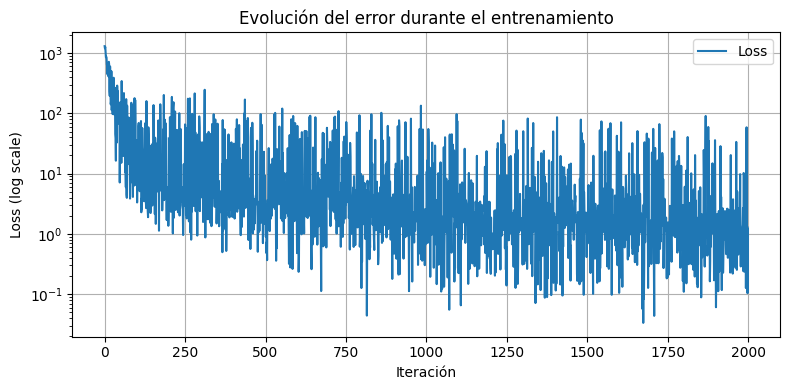

In [46]:
plot_training_error(errors)


In [47]:
def plot_solution_and_orbits_fixed_b(ANN, u0_values, phi_range=(0.0, 6.5), rs=2.0, b=5.0):
    """
    Grafica u(φ) y órbitas cartesianas para varios valores de u₀, con b fijo.
    Usa solve_u() para solución numérica y compara con la PINN.
    """
    ANN.eval()
    device = next(ANN.parameters()).device

    fig, axes = plt.subplots(len(u0_values), 2, figsize=(14, 5 * len(u0_values)), squeeze=False)
    phi_plot = torch.linspace(phi_range[0], phi_range[1], 200, device=device).view(-1, 1)

    for i, u0 in enumerate(u0_values):
        ax_sol = axes[i, 0]
        ax_orbit = axes[i, 1]

        ax_sol.set_title(f'Solución u(ϕ) para u₀ = {u0:.2f}')
        ax_sol.set_xlabel('ϕ')
        ax_sol.set_ylabel('u(ϕ)')
        ax_sol.grid(True)

        ax_orbit.set_title(f'Órbita cartesiana para u₀ = {u0:.2f}')
        ax_orbit.set_xlabel('x')
        ax_orbit.set_ylabel('y')
        ax_orbit.set_aspect('equal')
        ax_orbit.grid(True)

        # === PINN ===
        u0_tensor = torch.full_like(phi_plot, u0, device=device)
        input_tensor = torch.cat([phi_plot, u0_tensor], dim=1)

        with torch.no_grad():
            u_pred = param(input_tensor, ANN).squeeze().cpu().numpy()

        phi_np = phi_plot.squeeze().cpu().numpy()
        ax_sol.plot(phi_np, u_pred, label='PINN', color='tab:blue')

        # === Solución numérica con solve_u ===
        try:
            phi_num, u_num = solve_u(phi_range, u0=u0, rs=rs, b=b)
            ax_sol.plot(phi_num, u_num, '--', label='Numérica', color='tab:orange')

            # MSE
            u_num_interp = np.interp(phi_np, phi_num, u_num)
            mse = np.mean((u_pred - u_num_interp)**2)
            ax_sol.legend(title=f"MSE = {mse:.2e}")

            # Órbita numérica
            valid_num = u_num > 0
            if np.any(valid_num):
                x_num, y_num = cartesian_orbit(phi_num[valid_num], u_num[valid_num], rs=rs)
                ax_orbit.plot(x_num, y_num, '--', label='Numérica', color='tab:orange')

        except (RuntimeError, ValueError) as e:
            print(f"[Error] u₀ = {u0:.2f}, b = {b:.2f} → {str(e)}")
            ax_sol.text(0.5, 0.5, 'Error en solución numérica', transform=ax_sol.transAxes,
                        ha='center', va='center', color='red', fontsize=12)

        # Órbita PINN
        valid = u_pred > 0
        if np.any(valid):
            x, y = cartesian_orbit(phi_np[valid], u_pred[valid], rs=rs)
            ax_orbit.plot(x, y, label='PINN', color='tab:blue')

        ax_orbit.legend()

    plt.tight_layout()
    plt.show()


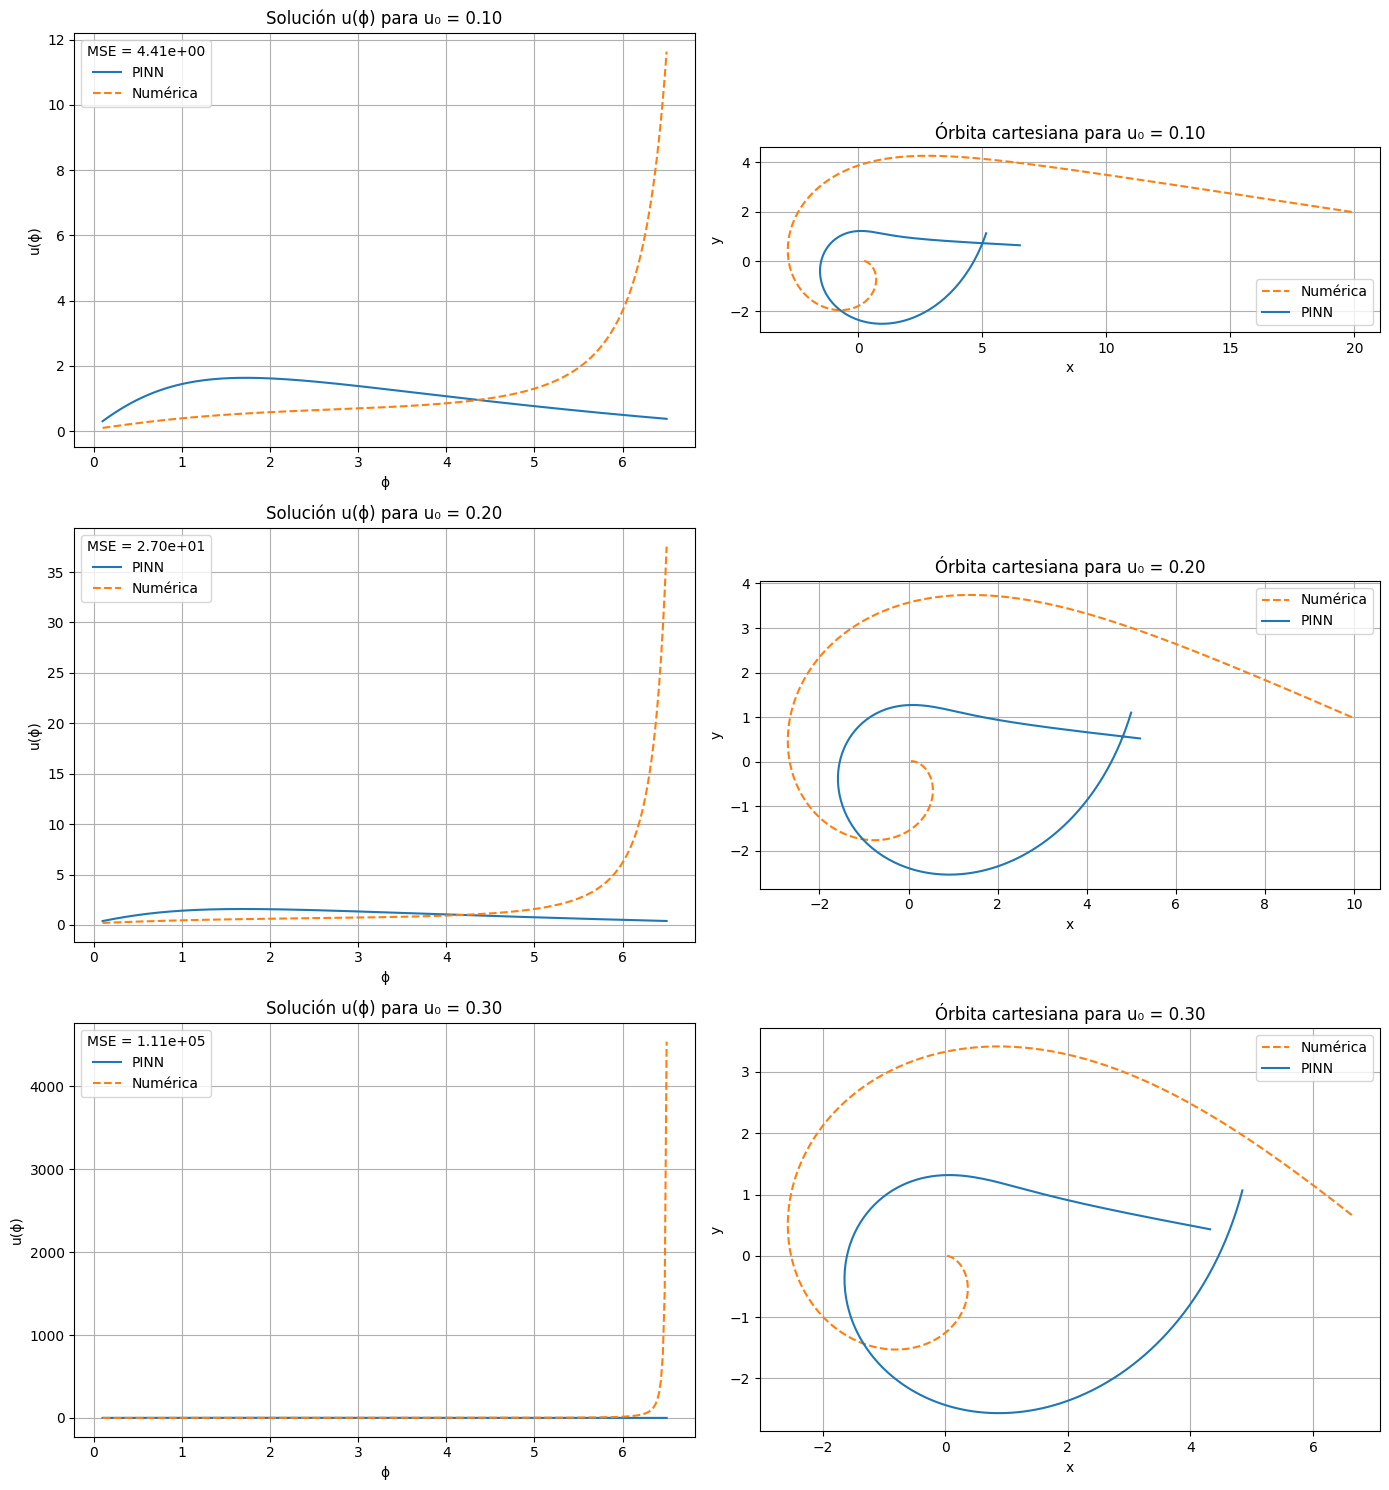

In [48]:
plot_solution_and_orbits_fixed_b(
    ANN,
    u0_values=[0.1, 0.2, 0.3],  # elige los u₀ que quieras comparar
    phi_range=(0.1, 6.5),           # rango de φ
    rs=2.0,                         # radio de Schwarzschild
    b=5.0                           # valor fijo de b
)
